In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

import os
import pickle
import json

from tqdm import tqdm_notebook
from scipy.io import wavfile
from copy import deepcopy

### Prepare Loaders

In [2]:
#path_dataset = '../input/'
path_dataset = '/home/edoardobucheli/Datasets/FSDKaggle2018'

path_train = os.path.join(path_dataset,'audio_train_16k')
path_test = os.path.join(path_dataset,'audio_test_16k')

### Load Label Data

In [3]:
train_data = pd.read_csv(os.path.join(path_dataset,'train_post_competition.csv'))
test_data = pd.read_csv(os.path.join(path_dataset,'test_post_competition_scoring_clips.csv'))

In [4]:
from utilities import get_all_classes_dict, get_classes_to_meta_dict, get_labels

In [5]:
num_to_label, label_to_num, n_classes = get_all_classes_dict(train_data)
label_to_meta, label_num_to_meta = get_classes_to_meta_dict(label_to_num)

In [6]:
data_cur = train_data[train_data['manually_verified']==1]
data_noi = train_data[train_data['manually_verified']==0]

In [7]:
meta_labels_all, labels_all = get_labels(train_data,label_to_meta, label_to_num)
meta_labels_cur, labels_cur = get_labels(data_cur,label_to_meta, label_to_num)
meta_labels_noi, labels_noi = get_labels(data_noi,label_to_meta, label_to_num)
meta_labels_test, labels_test = get_labels(test_data,label_to_meta, label_to_num)

In [8]:
n_meta_classes = len(np.unique(meta_labels_all))

### Load Data

In [9]:
pickle_train = './preprocessed_train/MS-80-HL512-WF16k-64k'
pickle_test = './preprocessed_test/MS-80-HL512-WF16k-64k'

In [10]:
with open(pickle_train,'rb') as fp:
    x_train = pickle.load(fp)
with open(pickle_test, 'rb') as fp:
    x_test = pickle.load(fp)

In [11]:
sr = 16000
file_length = 64000
hop_length = 512
n_mels = 80

frames = int(np.ceil(file_length/hop_length))

### Load Network

In [12]:
from CNNetworks2D import malley_cnn_80
from tensorflow.keras.optimizers import Adam

In [13]:
input_shape = ([n_mels,frames])
lr = 0.001
mc_model = malley_cnn_80(input_shape,n_meta_classes)
mc_model.compile(optimizer=Adam(lr),loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])
#mc_model.save_weights('./weights_mc_malley.h5')
mc_model.load_weights('./weights_mc_malley.h5')
#mc_model.summary()

### Make Inference

In [14]:
from utilities import create_quick_test

In [15]:
x_test_2 = create_quick_test(x_test,1600,80,125)

In [16]:
mc_model.evaluate(x_test_2,meta_labels_test)

1600/1600 [==============================] - 2s 1ms/step


[0.4359323843475431, 0.91]

In [17]:
y_scores = mc_model.predict(x_test_2)

In [18]:
y_hat = np.argmax(y_scores, axis = 1)

In [19]:
del(mc_model)

### Plot Confusion Matrix

In [20]:
from utilities import plot_cm

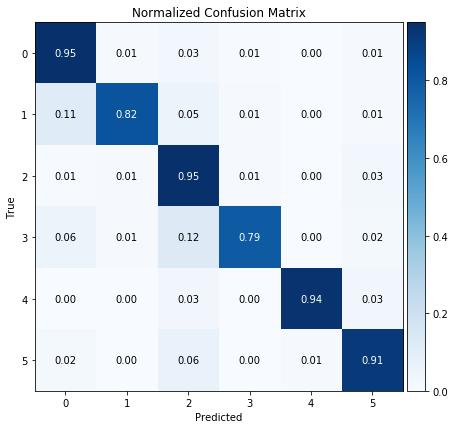

In [21]:
plot_cm(meta_labels_test,y_hat,figsize = (7,7))

### Separate Given Inference

In [36]:
c0_indx = [i for i,f in enumerate(y_hat) if f == 0]
c1_indx = [i for i,f in enumerate(y_hat) if f == 1]
c2_indx = [i for i,f in enumerate(y_hat) if f == 2]
c3_indx = [i for i,f in enumerate(y_hat) if f == 3]
c4_indx = [i for i,f in enumerate(y_hat) if f == 4]
c5_indx = [i for i,f in enumerate(y_hat) if f == 5]

### Cluster 0 

In [37]:
x0 = [x_test[f] for f in c0_indx]
y0 = [labels_test[f] for f in c0_indx]

In [38]:
with open('./c0_mapping', 'rb') as fp:
    c0_label_mapping = pickle.load(fp)

In [39]:
c0_labels = [8,18,22,29,30,37,38]

In [40]:
y0_2 = []

for f in y0:
    if f in c0_labels:
        y0_2.append(c0_label_mapping[f])
    else:
        y0_2.append(7)

In [41]:
modelc0 = malley_cnn_80((80,125),8)
modelc0.load_weights('./weights_c0_malley.h5')
modelc0.compile(optimizer=Adam(lr),loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])

In [42]:
x0_2 = create_quick_test(x0,len(x0),80,125)


modelc0.evaluate(x0_2,y0_2)

77/77 [==============================] - 0s 3ms/step


[0.5962952623119602, 0.844155846478103]

In [43]:
y_scores = modelc0.predict(x0_2)
y_hat = np.argmax(y_scores,axis = 1)

In [44]:
np.mean(y_hat == y0_2)

0.8441558441558441

In [45]:
from utilities import plot_cm

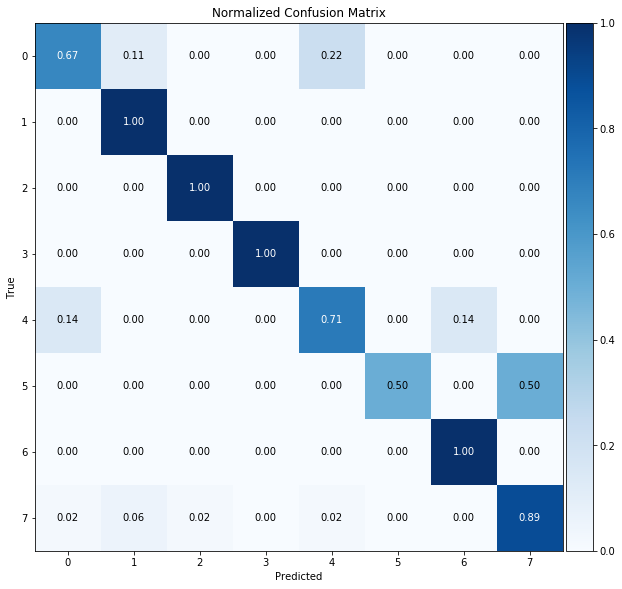

In [46]:
plot_cm(y0_2,y_hat,figsize = (10,10))
del(modelc0)

### Cluster 1

In [37]:
x1 = [x_test[f] for f in c1_indx]
y1 = [labels_test[f] for f in c1_indx]

In [2]:
with open('./c1_mapping', 'rb') as fp:
    c1_label_mapping = pickle.load(fp)

In [5]:
c1_labels = list(c1_label_mapping.keys())

In [40]:
y1_2 = []

for f in y1:
    if f in c1_labels:
        y1_2.append(c1_label_mapping[f])
    else:
        y1_2.append(len(c1_labels))

In [41]:
modelc1 = malley_cnn_80((80,125),len(c1_labels)+1)
modelc1.load_weights('./weights_c1_malley.h5')
modelc1.compile(optimizer=Adam(lr),loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])

In [42]:
x1_2 = create_quick_test(x1,len(x1),80,125)


modelc1.evaluate(x1_2,y1_2)

77/77 [==============================] - 0s 3ms/step


[0.5962952623119602, 0.844155846478103]

In [43]:
y_scores = modelc1.predict(x1_2)
y_hat = np.argmax(y_scores,axis = 1)

In [44]:
np.mean(y_hat == y1_2)

0.8441558441558441

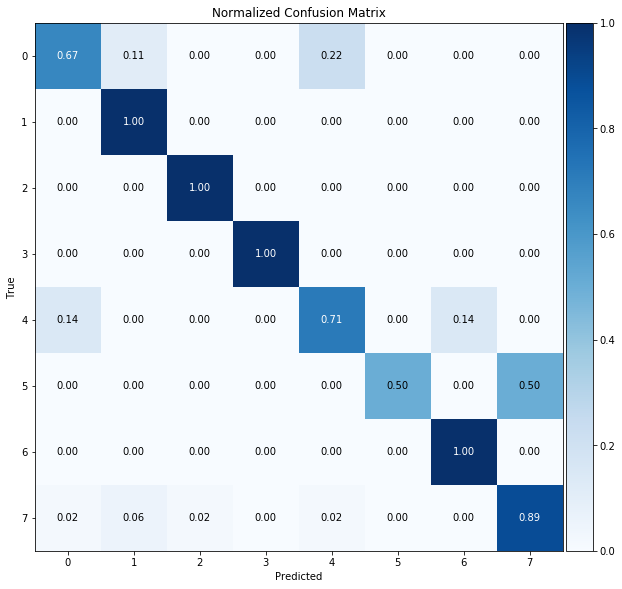

In [46]:
plot_cm(y1_2,y_hat,figsize = (7,7))
del(modelc1)

### Cluster 2

In [37]:
x2 = [x_test[f] for f in c2_indx]
y2 = [labels_test[f] for f in c2_indx]

In [2]:
with open('./c2_mapping', 'rb') as fp:
    c2_label_mapping = pickle.load(fp)

In [5]:
c2_labels = list(c2_label_mapping.keys())

In [40]:
y2_2 = []

for f in y2:
    if f in c2_labels:
        y2_2.append(c2_label_mapping[f])
    else:
        y2_2.append(len(c2_labels))

In [41]:
modelc2 = malley_cnn_80((80,125),len(c2_labels)+1)
modelc2.load_weights('./weights_c2_malley.h5')
modelc2.compile(optimizer=Adam(lr),loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])

In [42]:
x2_2 = create_quick_test(x2,len(x2),80,125)


modelc2.evaluate(x2_2,y2_2)

77/77 [==============================] - 0s 3ms/step


[0.5962952623119602, 0.844155846478103]

In [43]:
y_scores = modelc2.predict(x2_2)
y_hat = np.argmax(y_scores,axis = 1)

In [44]:
np.mean(y_hat == y2_2)

0.8441558441558441

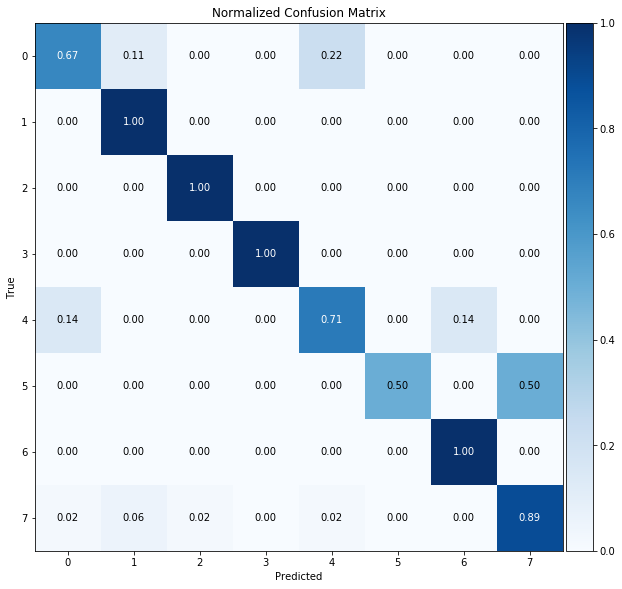

In [46]:
plot_cm(y2_2,y_hat,figsize = (7,7))
del(modelc2)

### Cluster 3

In [37]:
x3 = [x_test[f] for f in c3_indx]
y3 = [labels_test[f] for f in c3_indx]

In [2]:
with open('./c3_mapping', 'rb') as fp:
    c3_label_mapping = pickle.load(fp)

In [5]:
c3_labels = list(c3_label_mapping.keys())

In [40]:
y3_2 = []

for f in y3:
    if f in c3_labels:
        y3_2.append(c3_label_mapping[f])
    else:
        y3_2.append(len(c3_labels))

In [41]:
modelc3 = malley_cnn_80((80,125),len(c3_labels)+1)
modelc3.load_weights('./weights_c3_malley.h5')
modelc3.compile(optimizer=Adam(lr),loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])

In [42]:
x3_2 = create_quick_test(x3,len(x3),80,125)


modelc3.evaluate(x2_2,y2_2)

77/77 [==============================] - 0s 3ms/step


[0.5962952623119602, 0.844155846478103]

In [43]:
y_scores = modelc3.predict(x3_2)
y_hat = np.argmax(y_scores,axis = 1)

In [44]:
np.mean(y_hat == y3_2)

0.8441558441558441

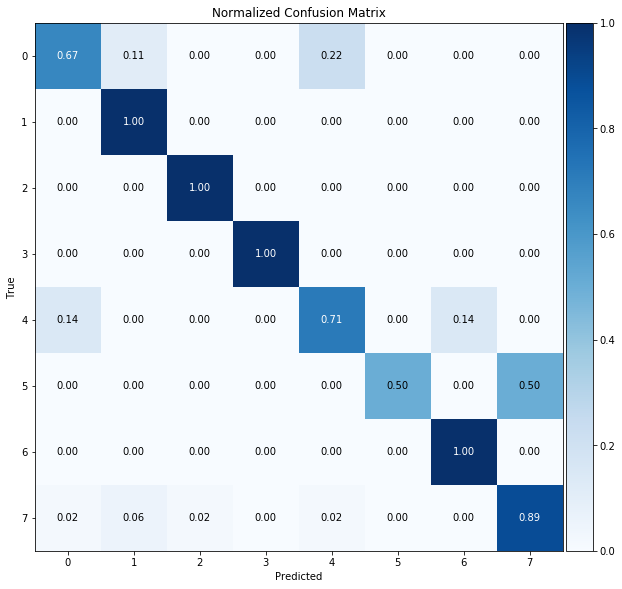

In [46]:
plot_cm(y3_2,y_hat,figsize = (7,7))
del(modelc3)

### Cluster 5

In [37]:
x5 = [x_test[f] for f in c5_indx]
y5 = [labels_test[f] for f in c5_indx]

In [2]:
with open('./c5_mapping', 'rb') as fp:
    c5_label_mapping = pickle.load(fp)

In [5]:
c5_labels = list(c5_label_mapping.keys())

In [40]:
y5_2 = []

for f in y5:
    if f in c5_labels:
        y5_2.append(c5_label_mapping[f])
    else:
        y5_2.append(len(c5_labels))

In [41]:
modelc5 = malley_cnn_80((80,125),len(c5_labels)+1)
modelc5.load_weights('./weights_c5_malley.h5')
modelc5.compile(optimizer=Adam(lr),loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])

In [42]:
x5_2 = create_quick_test(x5,len(x5),80,125)


modelc3.evaluate(x5_2,y5_2)

77/77 [==============================] - 0s 3ms/step


[0.5962952623119602, 0.844155846478103]

In [43]:
y_scores = modelc3.predict(x5_2)
y_hat = np.argmax(y_scores,axis = 1)

In [44]:
np.mean(y_hat == y5_2)

0.8441558441558441

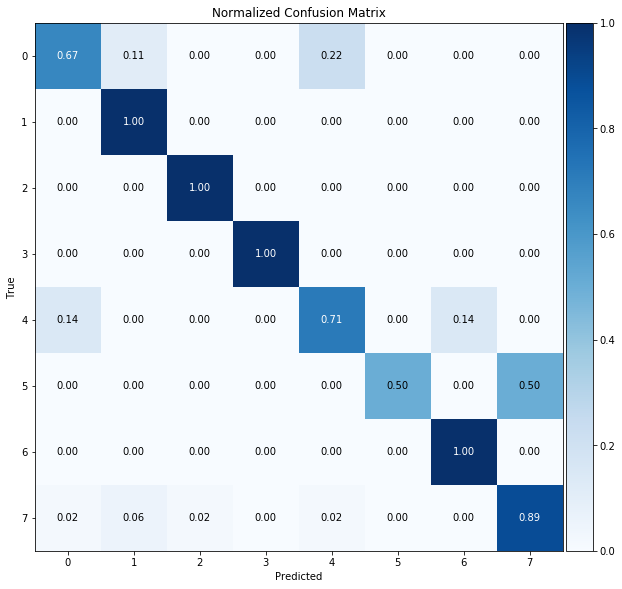

In [46]:
plot_cm(y5_2,y_hat,figsize = (7,7))
del(modelc5)